In [1]:
from pyspark.sql import SparkSession

In [2]:
# 버킷명 읽어오기
import os

bucket_name = os.environ.get('S3_BUCKET_NAME')

In [4]:
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages "org.apache.hadoop:hadoop-aws:3.3.4" pyspark-shell'

In [5]:
spark = SparkSession.builder \
    .appName("S3JSONAnalysis") \
    .config("spark.jars.packages", "org.apache.hadoop:hadoop-aws:3.3.4") \
    .getOrCreate()

/spark/bin/load-spark-env.sh: line 68: ps: command not found


:: loading settings :: url = jar:file:/spark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
org.apache.hadoop#hadoop-aws added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-1484c337-a166-47df-93ae-bd82f76b8fe2;1.0
	confs: [default]
	found org.apache.hadoop#hadoop-aws;3.3.4 in central
	found com.amazonaws#aws-java-sdk-bundle;1.12.262 in central
	found org.wildfly.openssl#wildfly-openssl;1.0.7.Final in central
:: resolution report :: resolve 126ms :: artifacts dl 6ms
	:: modules in use:
	com.amazonaws#aws-java-sdk-bundle;1.12.262 from central in [default]
	org.apache.hadoop#hadoop-aws;3.3.4 from central in [default]
	org.wildfly.openssl#wildfly-openssl;1.0.7.Final from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	-----------------------------------------------

In [38]:
webtoon_no = "802079"

In [10]:
# s3 bucket에서 데이터 읽어오기
df = spark.read \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .json(f"s3a://{bucket_name}/{webtoon_no}/*.json")

In [11]:
df.printSchema()

root
 |-- comment: string (nullable = true)
 |-- comment_id: string (nullable = true)
 |-- epi_no: long (nullable = true)
 |-- is_best: boolean (nullable = true)
 |-- login_id: string (nullable = true)
 |-- nickname: string (nullable = true)
 |-- recomm_cnt: string (nullable = true)
 |-- reply_cnt: string (nullable = true)
 |-- save_date: string (nullable = true)
 |-- title_id: string (nullable = true)
 |-- unrecomm_cnt: string (nullable = true)
 |-- write_date: string (nullable = true)



In [12]:
df.show()

+------------------------------------+----------+------+-------+--------+------------+----------+---------+-----------------+--------+------------+--------------------+
|                             comment|comment_id|epi_no|is_best|login_id|    nickname|recomm_cnt|reply_cnt|        save_date|title_id|unrecomm_cnt|          write_date|
+------------------------------------+----------+------+-------+--------+------------+----------+---------+-----------------+--------+------------+--------------------+
|     선우 대박이다.. 일단 예지가 ...| 451675904|    23|   true|yuso****|        청명|     11858|       10|1683179830.918526|  802079|           2|2023-03-04T23:10:...|
|   거침없는 청아에 정신 못 차리는...| 451672962|    23|   true|bbuy****|         bbu|      8096|        9|1683179834.674747|  802079|           8|2023-03-04T23:01:...|
|김요한 질투한다 개귀엽다 그냥 다해라| 451671337|    23|   true|ganx****|    ganx****|      7494|        9|1683179836.634221|  802079|           3|2023-03-04T22:54:...|
|   일단 내키는 대로 라는 말에꽂혓...| 45

In [37]:
from pyspark.sql.functions import regexp_replace

complete_hangul_df = df.withColumn("sentence", regexp_replace(comment_df["comment"], "[^가-힣\s]+", ""))\
                    .drop("comment")
complete_hangul_df.show()

+----------+------+-------+--------+------------+----------+---------+-----------------+--------+------------+--------------------+------------------------------------+
|comment_id|epi_no|is_best|login_id|    nickname|recomm_cnt|reply_cnt|        save_date|title_id|unrecomm_cnt|          write_date|                            sentence|
+----------+------+-------+--------+------------+----------+---------+-----------------+--------+------------+--------------------+------------------------------------+
| 451675904|    23|   true|yuso****|        청명|     11858|       10|1683179830.918526|  802079|           2|2023-03-04T23:10:...|   선우 대박이다 일단 예지가 자기...|
| 451672962|    23|   true|bbuy****|         bbu|      8096|        9|1683179834.674747|  802079|           8|2023-03-04T23:01:...|   거침없는 청아에 정신 못 차리는...|
| 451671337|    23|   true|ganx****|    ganx****|      7494|        9|1683179836.634221|  802079|           3|2023-03-04T22:54:...|김요한 질투한다 개귀엽다 그냥 다해라|
| 451671242|    23|   true|ahj

In [42]:
complete_hangul_df\
    .coalesce(1)\
    .write\
    .mode("overwrite")\
    .json(f"complete_hangul_output_{webtoon_no}.json")

In [43]:
loaded_df = spark.read.json(f"complete_hangul_output_{webtoon_no}.json")
loaded_df.show()

+----------+------+-------+--------+------------+----------+---------+-----------------+------------------------------------+--------+------------+--------------------+
|comment_id|epi_no|is_best|login_id|    nickname|recomm_cnt|reply_cnt|        save_date|                            sentence|title_id|unrecomm_cnt|          write_date|
+----------+------+-------+--------+------------+----------+---------+-----------------+------------------------------------+--------+------------+--------------------+
| 451675904|    23|   true|yuso****|        청명|     11858|       10|1683179830.918526|   선우 대박이다 일단 예지가 자기...|  802079|           2|2023-03-04T23:10:...|
| 451672962|    23|   true|bbuy****|         bbu|      8096|        9|1683179834.674747|   거침없는 청아에 정신 못 차리는...|  802079|           8|2023-03-04T23:01:...|
| 451671337|    23|   true|ganx****|    ganx****|      7494|        9|1683179836.634221|김요한 질투한다 개귀엽다 그냥 다해라|  802079|           3|2023-03-04T22:54:...|
| 451671242|    23|   true|ahj

In [45]:
sentences = loaded_df\
                .select("sentence")\
                .rdd\
                .flatMap(lambda x: x)\
                .collect()

print(sentences)

['선우 대박이다 일단 예지가 자기 약점이 아니라는 부분에서 콕 집어서 말하는 거  당사자 없을 땐 당사자 말하는 거 아니라고 함  요한이의 질투 부분을 맥스로 끌어올려줌  짱이다 김선우', '거침없는 청아에 정신 못 차리는 남자들', '김요한 질투한다 개귀엽다 그냥 다해라', '일단 내키는 대로 라는 말에꽂혓다는거부터부부가될준비가되엇다는뜻임', '무슨 청아를 무 뽑듯이', '선우 미친 진짜 순수하게 생겻으면서 꼬리 개 달린 여우같음', '요한이의 말에 의하면 선우는 남의 연애 얘기를 좋아하는 성격이 아님 근데 저렇게 관심을 가지는 이유가 있을 거라고 생각함 물론 보기 좋아서일 수도 있지만 자신이 좋아하는 예지가 요한이한테 관심을 가지니까 차라리 얼른 사겨버려라 이런 마음도 있지 않을까', '예지는 나에게 있어서 약점이 아니래 진짜 너무 다정하다 선우예지 얘기도 많이 보고싶다', '어쩔줄 몰라하는 요한 선우 왤케 귀엽냐', '예지 건조하게 생긴게 너무 취향이에요 바지 입은 것도 이미지랑 잘 어울리고', '선우 뭔가 생각이 깊어보임 뭔가 아무도 모르는 속마음을 가지고 있는애 처럼보임 뭔가 생각이 다 드러나는 타입은 아닌데 뭐지 근데 또 밝고 착한데 뭐지 이 느낌은', '선우야 너무 귀엽다 너무 사랑스러워 똑 부러지고 진짜 맨날 볼 붉은 것도 진짜 작가님한테 그랜절 박고 싶을 정도로 귀여워', '아니 선우 남자인거 저번화에도 대놓고 명시했고 전부터 떡밥 꽤나 나왔던 것 같은데 남자였냐는 댓글이 계속 나오니까 보기 째꼼 그럼', '선우야 나랑결혼해선우야 나랑결혼해선우야 나랑결혼해선우야 나랑결혼해선우야 나랑결혼해선우야 나랑결혼해선우야 나랑결혼해선우야 나랑결혼해선우야 나랑결혼해선우야 나랑결혼해선우야 나랑결혼해선우야 나랑결혼해선우야 나랑결혼해선우야 나랑결혼해선우야 나랑결혼해선우야 나랑결혼해선우야 나랑결혼해선우야 나랑결혼해선우야 나랑결혼해선우야 나랑결혼해선우야 나랑결혼해선우야 나랑결혼해선우야 나랑결혼해선우야 나랑결혼해선우야 나랑결혼해선우야 나랑결혼해선우야 나랑결혼해선우야 

In [47]:
from konlpy.tag import Kkma
from konlpy.utils import pprint

kkma = Kkma()

In [52]:
comment_nouns = []

for sentence in sentences:
    kkma_nouns = kkma.nouns(sentence)
    nouns = [noun for noun in kkma_nouns if len(noun) >= 2]
    comment_nouns.extend(nouns)
    
print(comment_nouns)

['선우', '대박', '예지', '자기', '약점', '부분', '당사자', '이의', '질투', '맥스', '김선우', '청아', '정신', '남자', '질투', '대로', '준비', '부가', '꽂혓', '청아', '선우', '진짜', '순수', '생겻으면', '꼬리', '여우', '이의', '선우', '연애', '얘기', '성격', '관심', '이유', '생각', '수도', '자신', '예지', '이한', '이한테', '마음', '예지', '약점', '니래', '다정', '선우', '선우예지', '얘기', '선우', '예지', '건조', '취향', '바지', '지랑', '선우', '생각', '보임', '아무', '속마음', '타입', '무엇', '느낌', '선우', '사랑', '진짜', '작가', '랜절', '정도', '선우', '남자', '저번', '명시', '떡밥', '댓글', '선우', '결혼', '선우', '이마', '뽀뽀', '유교', '유교보이', '보이', '천년', '천년재림교', '재림', '우리', '표현', '키스', '키스라', '이마', '이마뽀뽀', '뽀뽀', '세상', '건전', '조금', '오른쪽', '세상', '뽀뽀', '그것', '몽사', '몽사몽', '상태', '회차', '일러스트', '러스트', '지금', '타이밍', '키스', '뽀뽀', '순수', '청아', '계란', '계란말', '뽀뽀', '화면', '키스', '키스장면', '장면', '청아', '김무원', '무원', '김무원', '무원', '상상', '청아', '귀김무원', '선우', '눈치', '환생', '트럭', '운전', '건전', '변태', '기분', '남녀', '동거', '뽀뽀', '서로', '커플', '이것', '인지', '부조화', '박력', '청아', '본인', '청아', '개설', '개설레', '명이', '무원', '성부', '성자', '성령', '이름', '악령', '물렀거', '렀거', '종교', '여기', '쿠키', '사람', '인원', '

In [53]:
from collections import Counter

noun_counter = Counter(comment_nouns)
print(noun_counter)

Counter({'청아': 67, '선우': 27, '여주': 26, '사랑': 24, '무원': 23, '사이비': 22, '작가': 21, '생각': 19, '진짜': 17, '뽀뽀': 14, '삼촌': 14, '웹툰': 13, '얼굴': 13, '남주': 12, '예지': 11, '러스트': 11, '남자': 10, '일러스트': 10, '외삼촌': 10, '자기': 9, '김무원': 9, '사람': 9, '상황': 9, '사이': 9, '키스': 8, '동거': 8, '여기': 8, '친구': 8, '우리': 7, '이것': 7, '쿠키': 7, '처음': 7, '내가': 7, '사기꾼': 7, '사기': 7, '질투': 6, '성격': 6, '느낌': 6, '세상': 6, '그림': 6, '주가': 6, '가족': 6, '연애': 5, '얘기': 5, '마음': 5, '무엇': 5, '결혼': 5, '스토리': 5, '감사': 5, '행복': 5, '완전': 5, '혼자': 5, '걱정': 5, '요즘': 5, '서브': 5, '이거': 5, '마카롱': 5, '여자': 5, '무진': 5, '전화': 5, '이유': 4, '지금': 4, '상상': 4, '눈치': 4, '종교': 4, '평생': 4, '와중': 4, '머리': 4, '고통': 4, '동네': 4, '시작': 4, '아기': 4, '학원': 4, '당황': 4, '표정': 4, '시간': 4, '교주': 4, '자극': 4, '마지막': 4, '눈물': 4, '남주가': 4, '주인공': 4, '이상': 4, '청춘': 4, '있음': 4, '심장': 4, '아들': 4, '간도': 4, '당사자': 3, '다정': 3, '선우예지': 3, '정도': 3, '저번': 3, '천년': 3, '천년재림교': 3, '재림': 3, '표현': 3, '장면': 3, '남녀': 3, '본인': 3, '이름': 3, '오늘': 3, '그림체': 3, '제목': 3, '인생': 3, '슬픔': 3,

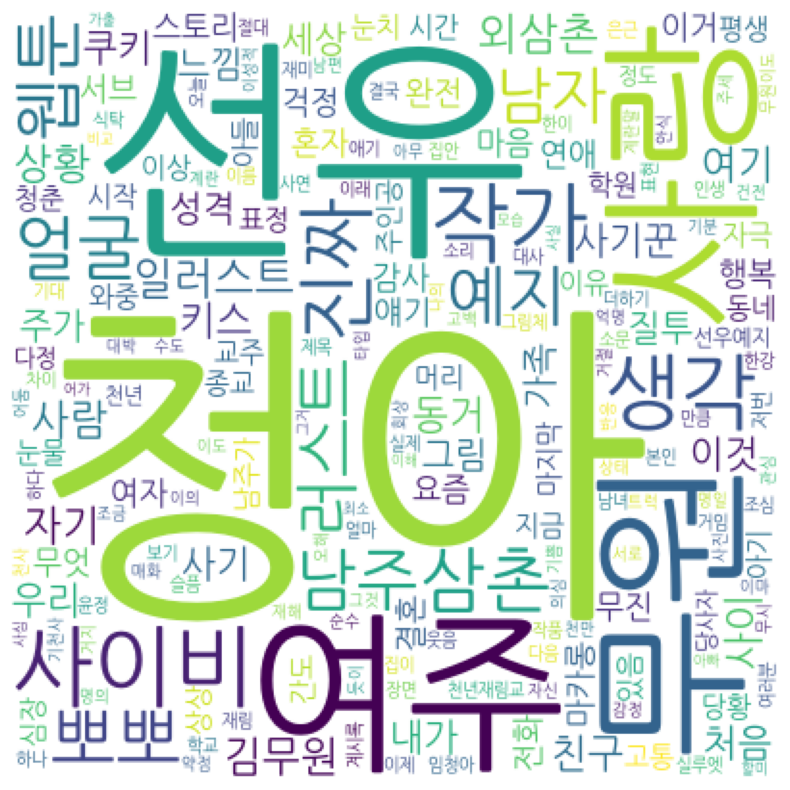

In [60]:
from wordcloud import WordCloud 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt


wc = WordCloud(random_state = 123, font_path='/usr/share/fonts/NanumFont/NanumGothic.otf', width = 400, height = 400, background_color = 'white')

img_wordcloud = wc.generate_from_frequencies(noun_counter)

plt.figure(figsize = (10, 10)) # 크기 지정하기
plt.axis('off') # 축 없애기
plt.imshow(img_wordcloud)